In [2]:
%load_ext autoreload
%autoreload 2

# add the parent directory in the path to import the packages
import sys
sys.path.append('../')

from WaterClassification.Radiometry import RadiometryDB
from WaterClassification.common import *
from WaterClassification.Fitting import BaseFit
from WaterClassification.Classification.clustering import *

from functools import partial
from itertools import product

from pathlib import Path

# Clustering Algorithm Performances
In the previous notebook we saw that with the same input features (wavelenghts) and same normalization, the different clustering algorithms achieved similar results until K=6.<br>
In this notebook we will increase the clustering to 15 to check if this convergence continues beyond K > 6.<br>
Additionally, we will check if the final clustering from the algorithms looks similar.


 ## Load the Database

In [7]:
# Open the Radiometry Database
db = RadiometryDB(r'D:\OneDrive - Agência Nacional de Águas\Data\GET-RadiometryDB')

db.load_radiometries(r_types=['Rrs', 'Rrs_OSOAA'], 
                     norm=True,                                                        # create the normalized bands and also the area
                     funcs=partial(calc_area, col_name='flatness', norm_band='700'),   # create the flatness band
                     qry="SPM > 0 and Status != 'Deleted' and Status != 'Suspicious'"  # clear deleted and no data
                    )
rrs = db.rdmtries['Rrs']

rrs.head(3)

Radiometries ['Rrs', 'Rrs_OSOAA'] loaded in dictionary .rdmtries


Area_2 Station_2    Measurement         Start_Date_2  SPM_2 Status_2  \
Id                                                                             
0   Descoberto   Ponto_1  20160318-1139  2016-03-18 11:39:00    7.0       Ok   
1   Descoberto   Ponto_2  20160318-1214  2016-03-18 12:14:00    8.4       Ok   
2   Descoberto   Ponto_3  20160318-1228  2016-03-18 12:28:00    5.8       Ok   

         Description_2  319       320       321  ...      n943      n944  \
Id                                               ...                       
0   GIANCARLO_ CAMP1_1  NaN  0.003272  0.003054  ...  0.000138  0.000127   
1   GIANCARLO_ CAMP1_2  NaN  0.002663  0.002460  ...  0.000193  0.000212   
2   GIANCARLO_ CAMP1_3  NaN  0.003356  0.003116  ...  0.000143  0.000146   

        n945      n946      n947      n948      n949      n950  n951  flatness  
Id                                                                              
0   0.000149  0.000184  0.000180  0.000186  0.000191  0.000213   NaN -1.480905  
1   0.000206  0.000210  0.000192  0.000204  0.000186  0.000189   NaN -1.484569  
2   0.000142  0.000146  0.000158  0.000165  0.000162  0.000154   NaN -1.755808  

[3 rows x 1289 columns]

In [8]:
# deleting outliers
rrs.drop(index=[410, 418, 390, 520, 409, 658], inplace=True, errors='ignore')
len(rrs)

869

## Compute the Multi Clustering until K=15 for the 3 algorithms
We will used fixed parameters for:
* Sampling 1nm (from 400 to 920)
* Reflectance types: raw + norm
* Post normalization: Standard
* Fitting bands: s2bands and ratio
<br>


In [9]:
def parse_combination(combination):
    sampling, ref_type, normalization, algo = combination
    
    # first, get the input wavelenghts
    if isinstance(sampling, int):
        wls = wavelength_range(400, 920, step=sampling)
        wls_name = f'{sampling}nm'
    else:
        wls = sampling[0]
        wls_name = sampling[1]
        
    # create the bands, according to the reflectance types
    bands = []
    ref_type_name = '' 
    for tp in listify(ref_type):
        ref_type_name = ref_type_name + tp
        if tp == 'raw':
            bands = bands + wls
        elif tp == 'norm':
            bands = bands + [f'n{b}' for b in wls]
        else:
            bands = bands + listify(tp)
            
    name = '_'.join([algo, wls_name, ref_type_name, str(normalization)])
    
    return bands, name, normalization, algo


def full_process_clustering(df, range_clusters, samplings, ref_types, normalizations, algos, fit_bands, funcs, calc=False, save=False, load=True):
    combinations = list(product(samplings, ref_types, normalizations, algos))
    
    print(f'Total of {len(combinations)} were created.')    
    
    results = {}
    for combination in combinations:
        cluster_bands, name, normalization, algo = parse_combination(combination)
        
        print(f'**** {name} ****')
        
        if calc:
            mcluster = MultiClustering(df,
                                       cluster_features=cluster_bands,
                                       range_clusters=range_clusters,
                                       algo=algo,
                                       norm=normalization)

            mcluster.fit(fit_features=fit_bands, 
                         funcs=funcs, 
                         n_cpus=6, 
                         pool=None,
                         optimize_metric=True)
        
            if save:
                # save the pandas summary
                result_df = mcluster.summary()
                result_df.to_csv(f'../data/{name}.csv')

                # save the figure
                fig = mcluster.plot_clustering('area', log_y=True)
                pio.write_image(fig, f'../data/{name}.png', width=1200, height=800)
            

            results[name] = mcluster
        
        elif load:
            results[name] = load_obj(f'../data/{name}.multicluster')

    return results


In [10]:
samplings = [1]
ref_types = [['raw', 'norm']]
normalizations = ['Standard']
algos = ['k-means', 'agglomerative', 'FCM']
fit_bands = s2bands + s2bands_norm + ['area', 'b865/b665']
clusters_range = (1, 16)
funcs = BaseFit.available_funcs

mclusters = full_process_clustering(rrs, clusters_range, samplings, ref_types, normalizations, algos, fit_bands, funcs, calc=False, save=False, load=True)

Total of 3 were created.
**** k-means_1nm_rawnorm_Standard ****
**** agglomerative_1nm_rawnorm_Standard ****
**** FCM_1nm_rawnorm_Standard ****


## Compare the overall results for the 3 clusterings
From the graph below, we can see that the results are pretty similar until K=15

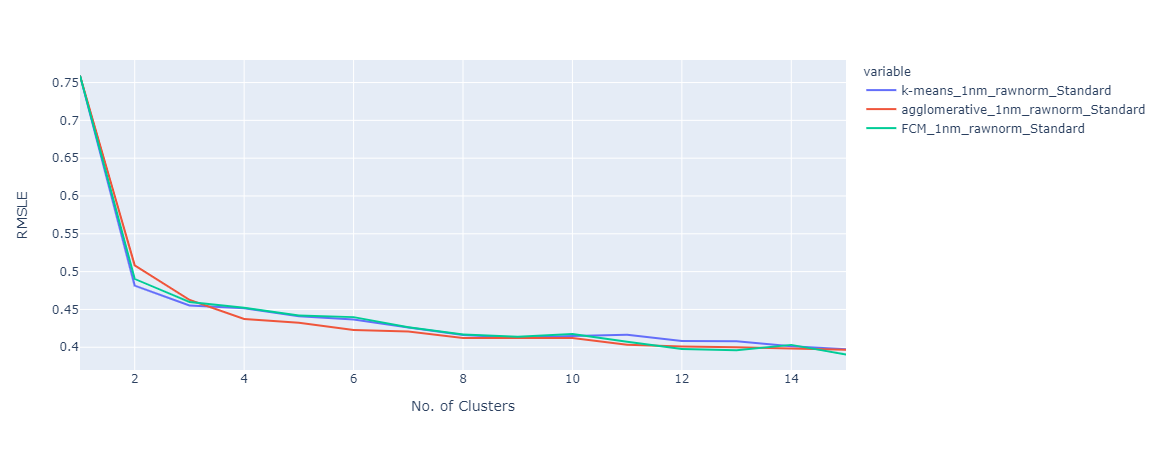

In [11]:
MultiClustering.plot_metric_by_cluster(mclusters.values(), mclusters.keys())

In [12]:
# for name, mcluster in mclusters.items():
#     mcluster.save_memory(max_n=1)
#     save_obj(mcluster, f'../data/{name}.multicluster')

## Analysing the differences with 4 clusters

### K-MEANS

In [13]:
kmeans = mclusters['k-means_1nm_rawnorm_Standard']
kmeans.sort_by_variable()
kmeans[4].group_fit.summary()

func       band     R^2         MSE      RMSE   RMSLE  \
0             Linear        740  0.4175      6.7127    2.5909  0.4513   
1        Exponential        705  0.4888     12.8672    3.5871  0.6159   
2              Power        842  0.3785   1581.0688   39.7627  0.4301   
3        Exponential  b865/b665  0.7613  27819.2649  166.7911  0.3432   
overall          NaN        NaN  0.8730   9533.4125   97.6392  0.4517   

                  SSE                                             params  qty  
0        9.531967e+02           [1966.6846725397263, 0.8479826172185905]  142  
1        2.174563e+03            [376.5230189625305, -376.2306135940454]  169  
2        4.363750e+05  [23747.210614756965, 1.299488574736984, 5.8046...  276  
3        7.845033e+06          [153.85172158855127, -198.96656905005153]  282  
overall  8.284535e+06                                               None  869

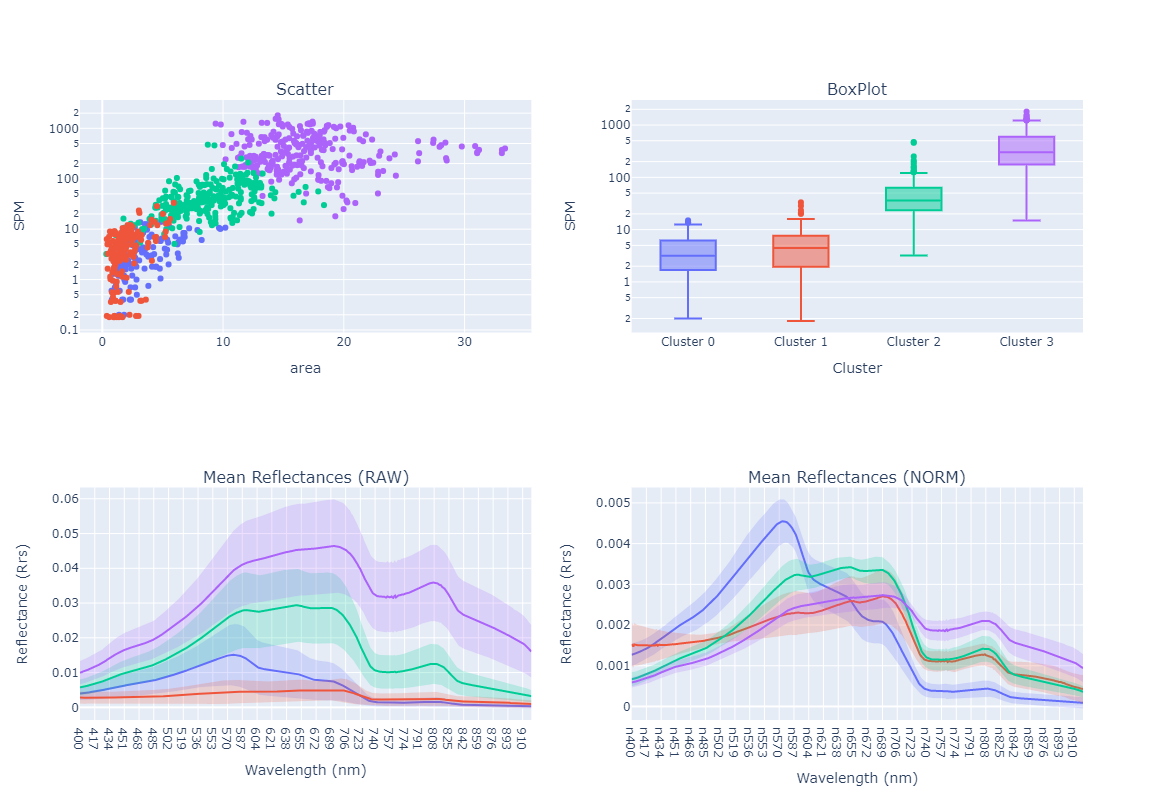

In [14]:
kmeans[4].plot_summary()

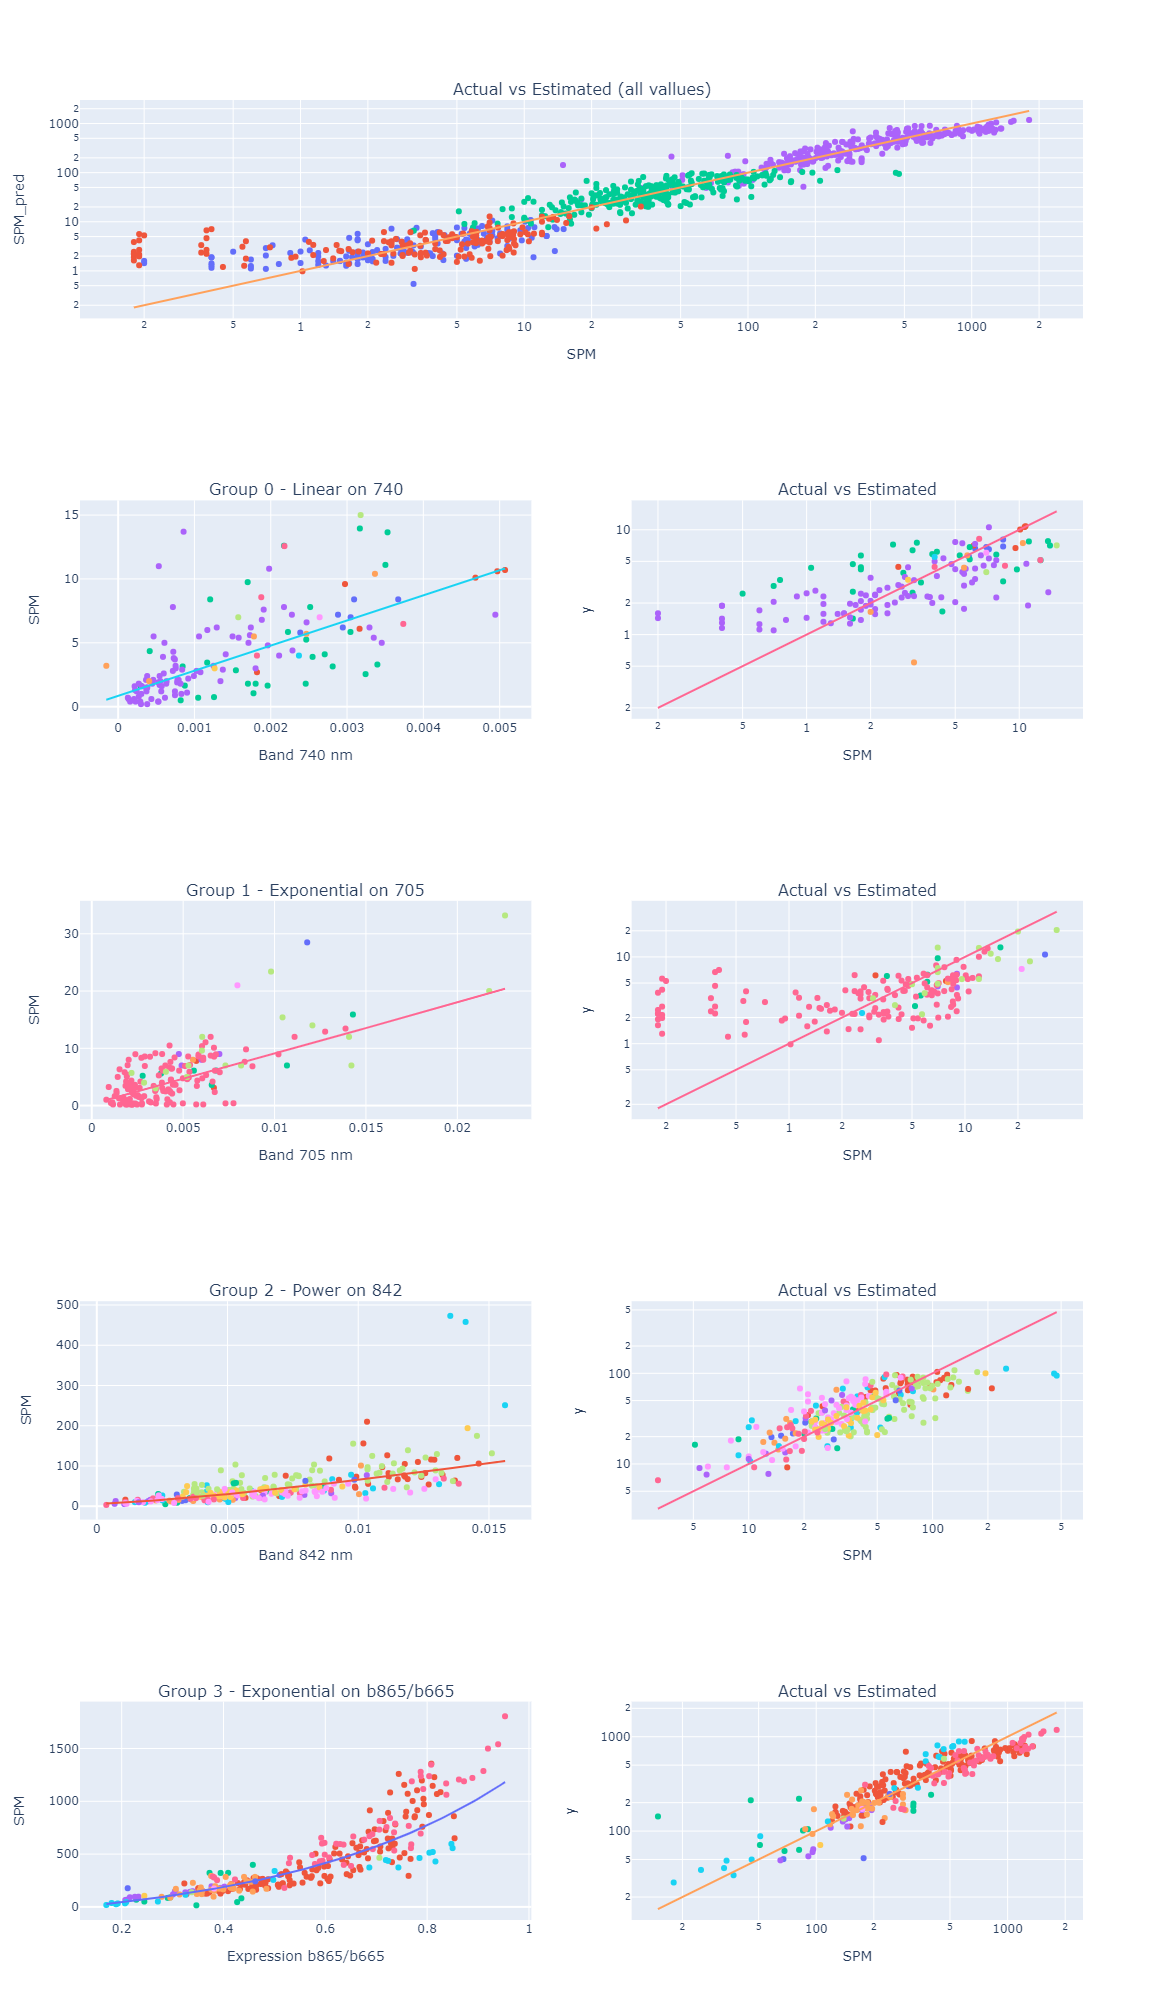

In [15]:
kmeans[4].group_fit.plot_groups_summary(color='Area')

### FCM

In [16]:
fcm = mclusters['FCM_1nm_rawnorm_Standard']
fcm.sort_by_variable()
fcm[4].group_fit.summary()

func       band     R^2         MSE      RMSE   RMSLE  \
0             Linear        740  0.4414      8.2440    2.8712  0.4589   
1        Exponential        705  0.5287     15.9522    3.9940  0.5928   
2              Power  b865/b665  0.7528   1000.5967   31.6322  0.4164   
3              Power  b865/b665  0.7682  27513.0102  165.8705  0.3474   
overall          NaN        NaN  0.8930   8030.0520   89.6106  0.4523   

                  SSE                                             params  qty  
0        1.187135e+03           [2044.1140877868056, 0.8060084932443883]  144  
1        3.094721e+03           [399.41071146209356, -399.2004229953901]  194  
2        2.881718e+05  [1975.2829101402226, 2.7183259276644676, 17.20...  288  
3        6.685661e+06  [1468.9014892281843, 2.766714074478199, 49.233...  243  
overall  6.978115e+06                                               None  869

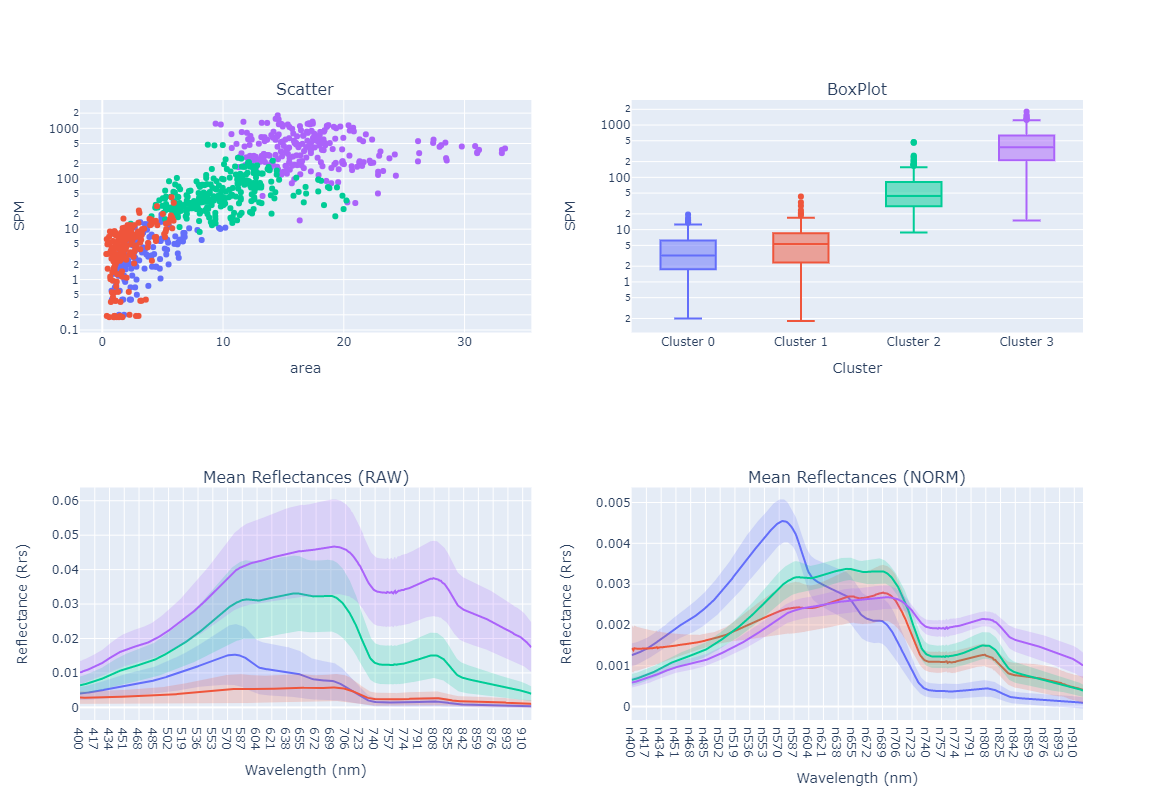

In [17]:
fcm[4].plot_summary()

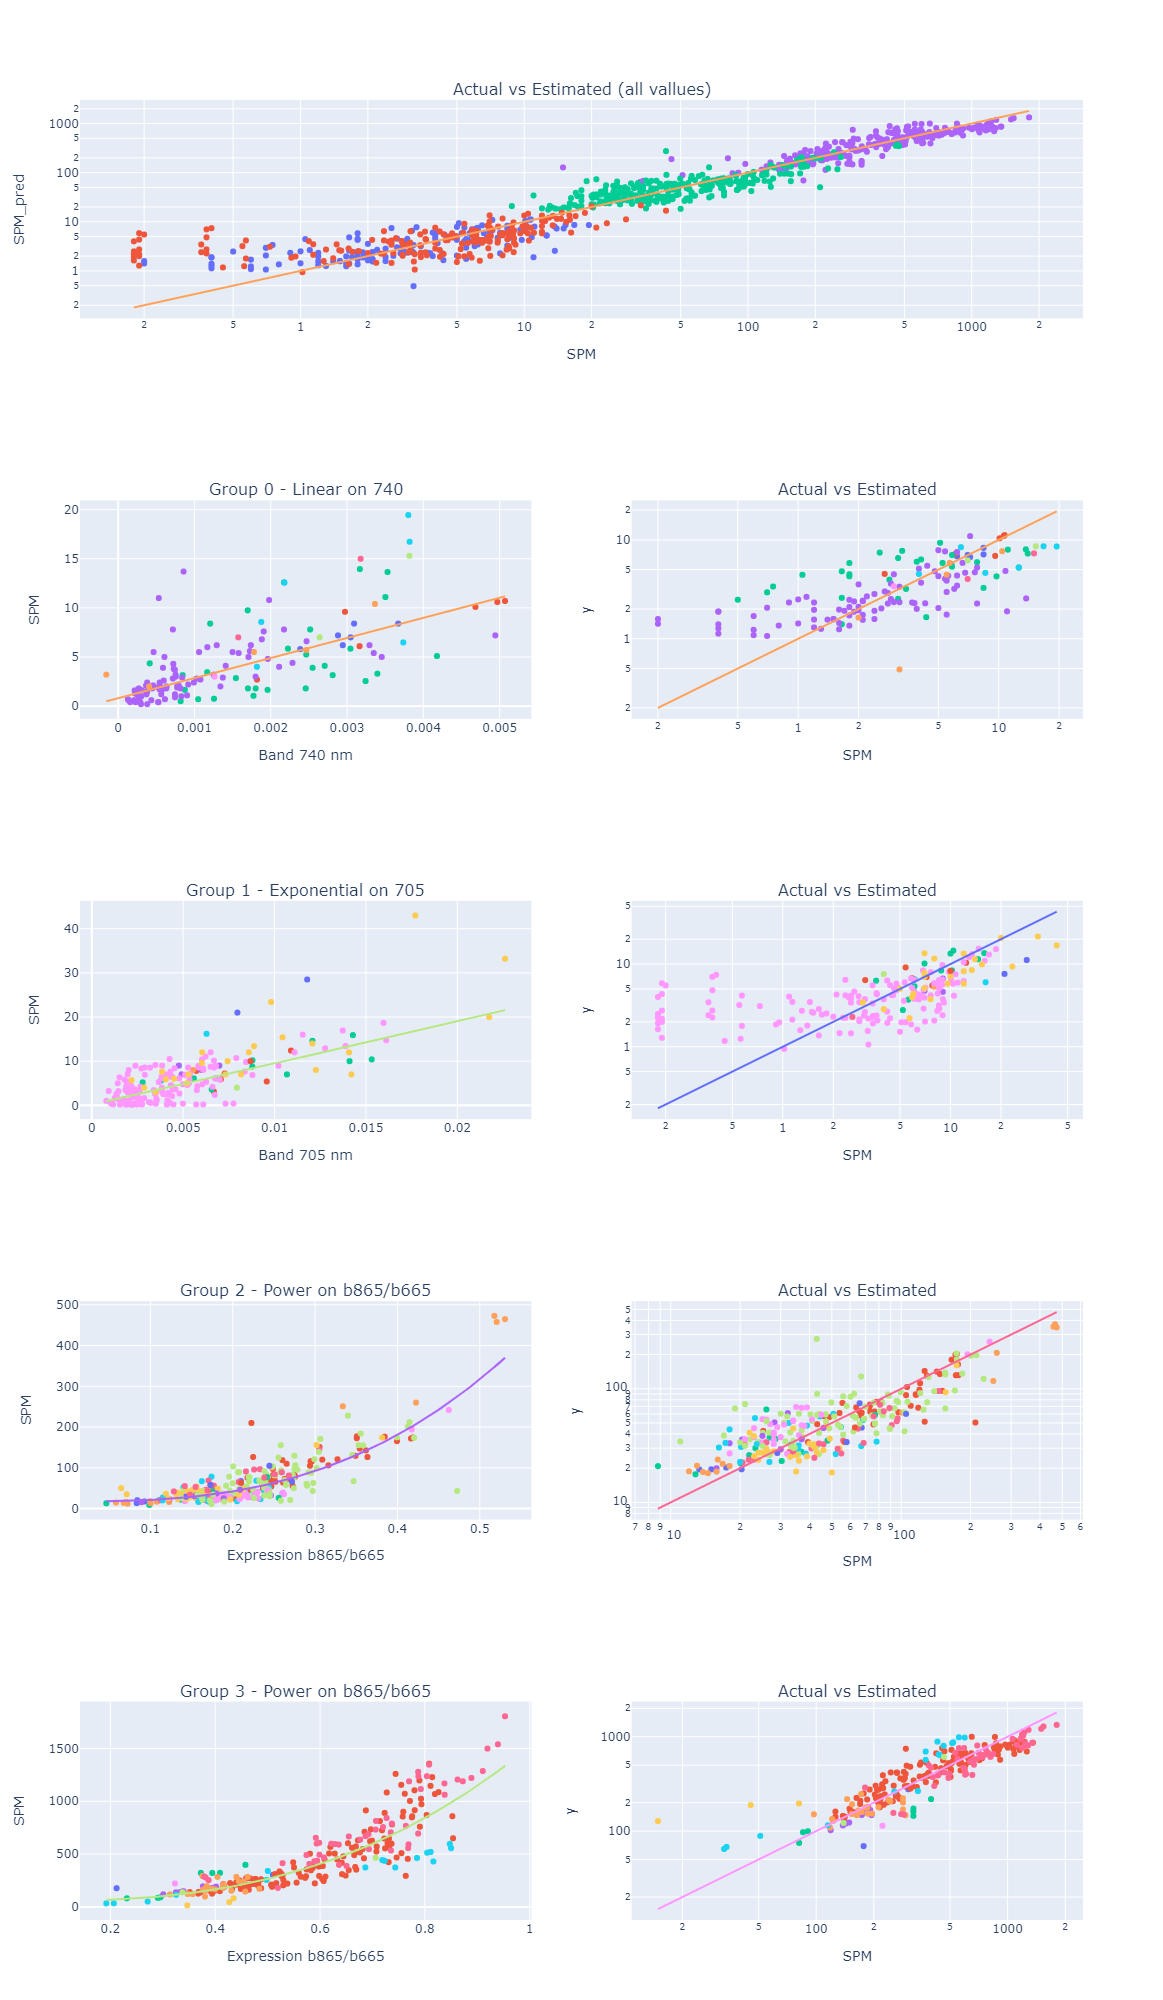

In [18]:
fcm[4].group_fit.plot_groups_summary(color='Area')

### Agglomerative

In [19]:
agg = mclusters['agglomerative_1nm_rawnorm_Standard']
agg.sort_by_variable()
agg[4].group_fit.summary()

func       band     R^2         MSE      RMSE   RMSLE  \
0        Exponential        705  0.4135     15.1147    3.8878  0.6408   
1        Exponential        740  0.6882      9.6098    3.1000  0.4427   
2        Exponential        783  0.5864    281.2159   16.7695  0.4266   
3              Power  b865/b665  0.8207  20203.4403  142.1388  0.3717   
overall          NaN        NaN  0.8861   8547.9224   92.4550  0.4373   

                  SSE                                             params  qty  
0        1.435897e+03          [241.95762075928195, -241.40884613858617]   95  
1        1.508733e+03            [906.8093884555981, -906.0294957383715]  157  
2        7.114763e+04            [1633.687918415104, -1633.469240198543]  253  
3        7.354052e+06  [1356.2732147497632, 2.3996323676913365, 21.35...  364  
overall  7.428145e+06                                               None  869

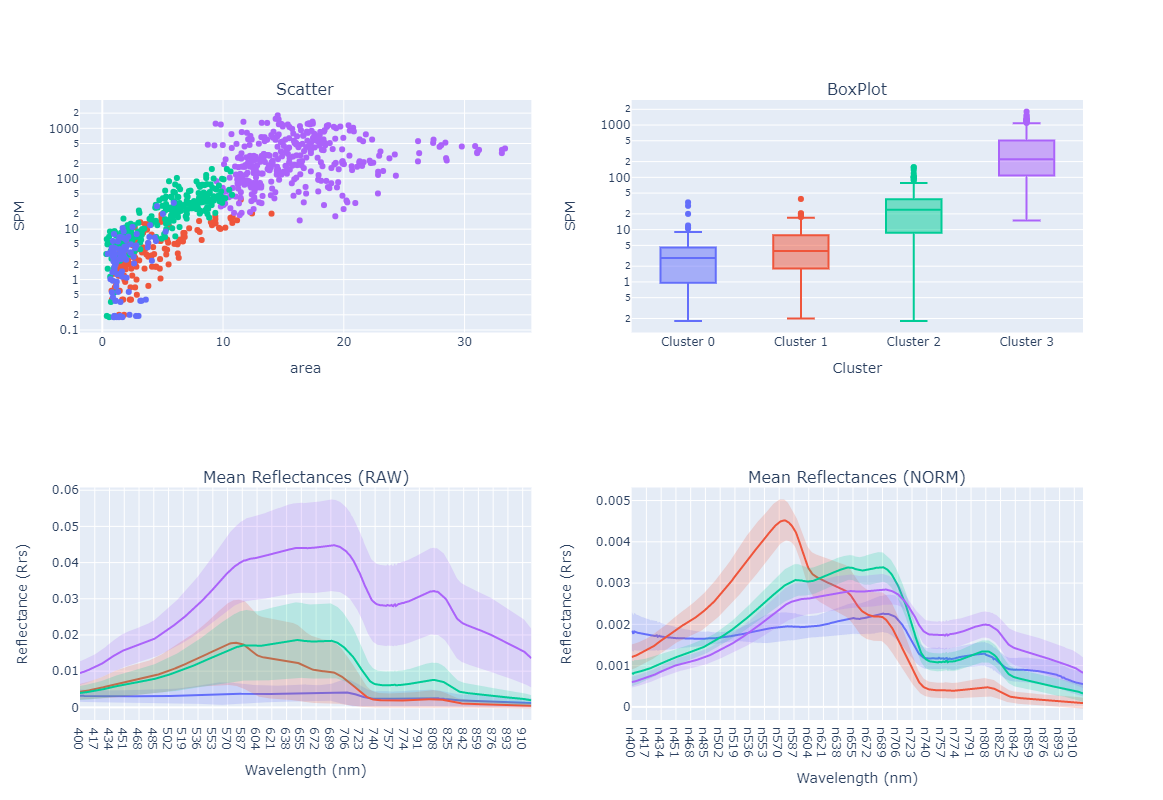

In [20]:
agg[4].plot_summary()

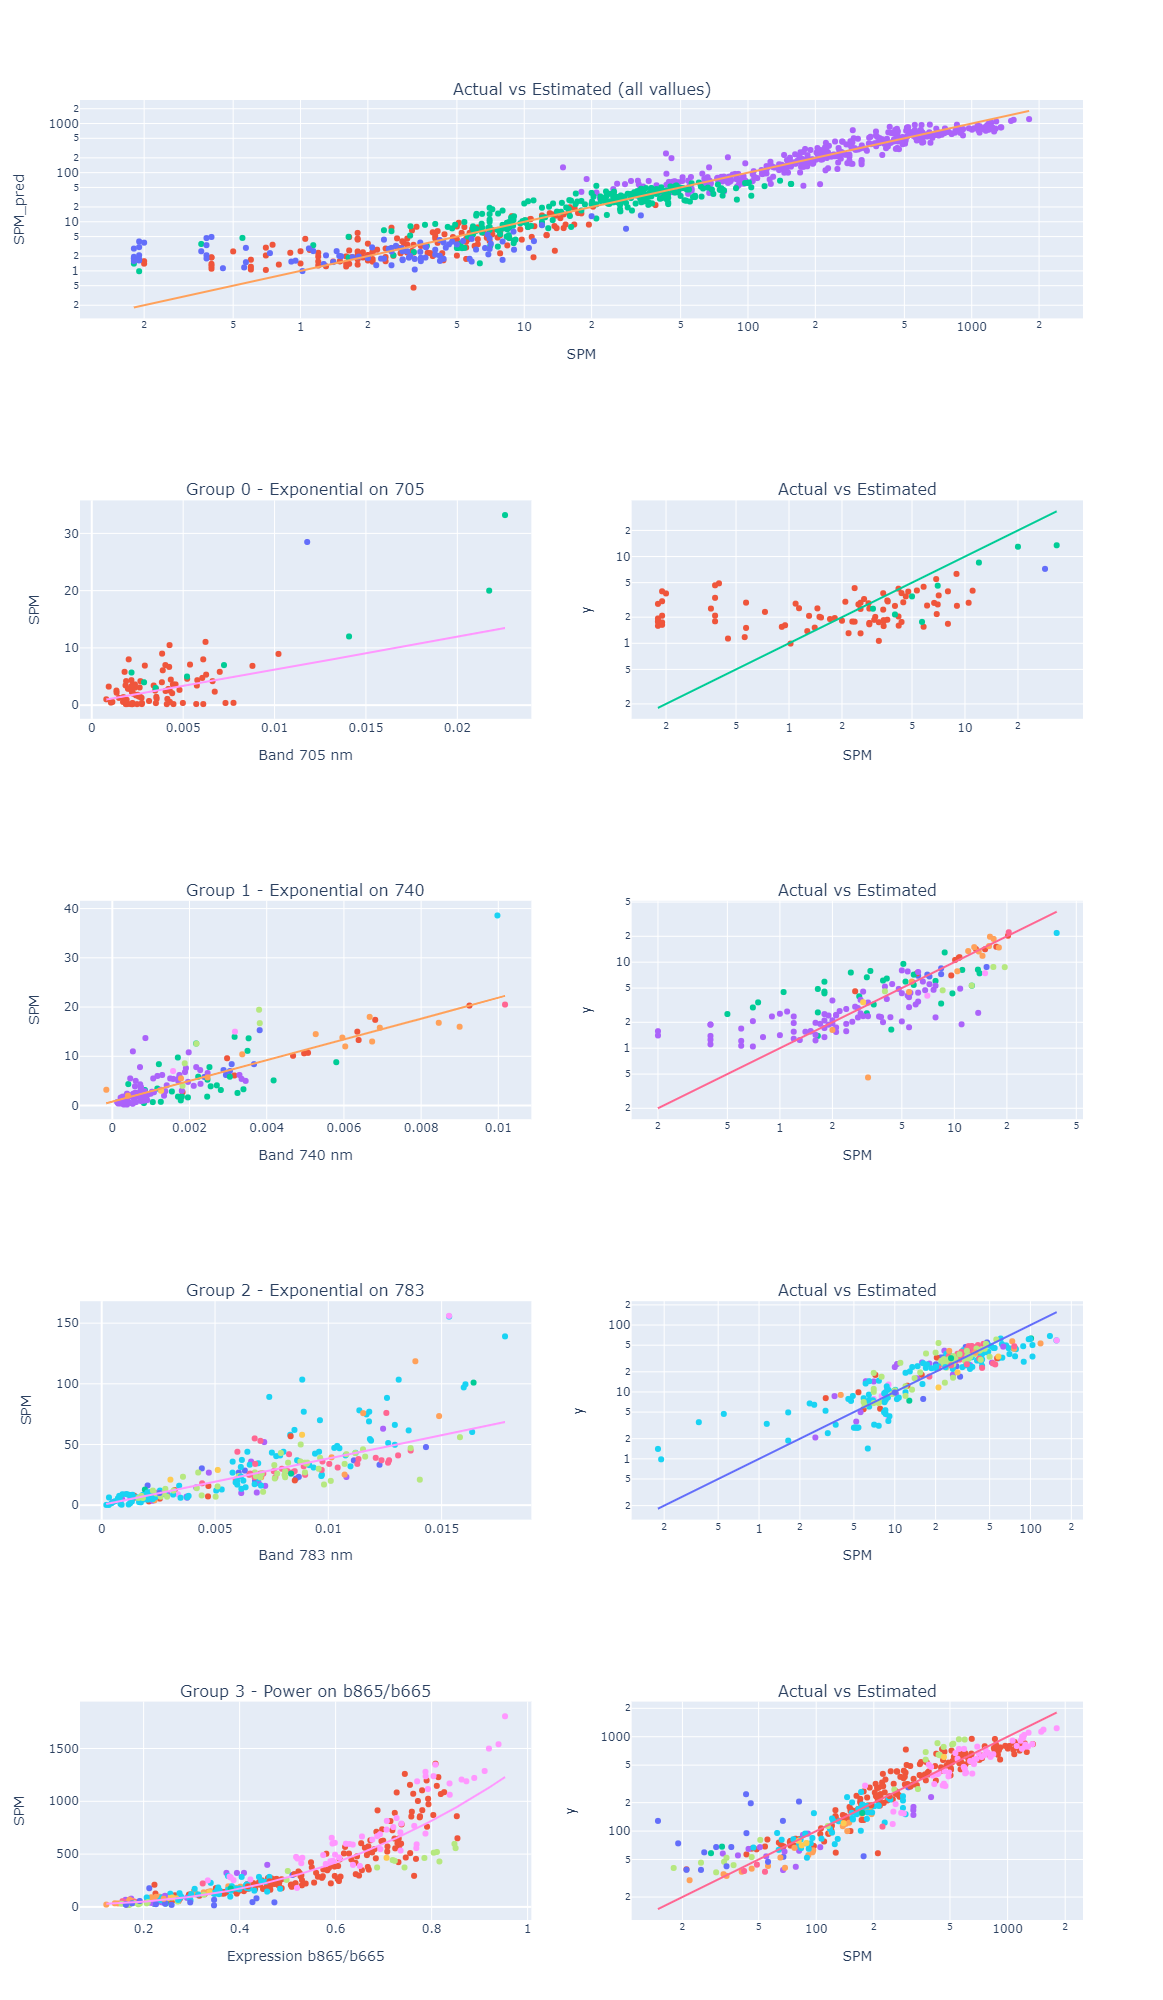

In [21]:
agg[4].group_fit.plot_groups_summary(color='Area')